# Project 3 : Tennis (Multi-Agents)

## Prepare the environment

If necessary, uncomment and execute the following commands to install the Python requirements for this project

In [1]:
#!pip -q install ../python
#!pip install --no-deps unityagents

Load the Unity environment. Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# Load a single agent of the environment
env = UnityEnvironment(file_name="./Tennis_Linux_NoVis/Tennis.x86_64")

# Get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# Imports
import random
import torch

import os
import numpy as np
from collections import deque
import time
import matplotlib.pyplot as plt

# Set plotting options
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(precision=3, linewidth=120)

# Hide Matplotlib deprecate warnings
import warnings
warnings.filterwarnings("ignore")

# High resolution plot outputs for retina display
%config InlineBackend.figure_format = 'retina'
 

In [4]:
# Path to save the mdoels and collect the Tensorboard logs
model_dir= os.getcwd()+"/model_dir"
os.makedirs(model_dir, exist_ok=True)

## Instantiate the Unity environment and the Agent

In [5]:
# Reset the environment    
env_info = env.reset(train_mode=True)[brain_name]     

# number of agents
num_agents = len(env_info.agents)

# size of each action
ENV_ACTION_SIZE = brain.vector_action_space_size

# size of the state space 
states = env_info.vector_observations  # Array of states for all agents in teh enviroonments
ENV_STATE_SIZE = states.shape[1]

print('There are {} agents. Each observes a state with length: {} and act within an action space of length: {}'.format(states.shape[0], 
                                                                                                                       ENV_STATE_SIZE, 
                                                                                                                       ENV_ACTION_SIZE))

There are 2 agents. Each observes a state with length: 24 and act within an action space of length: 2


### Take Random Actions in the Environment

In [6]:
def random_agents():    
    for i_episode in range(1, 6):                              # play game for 5 episodes
        env_info = env.reset(train_mode=False)[brain_name]     # reset the environment
        states = env_info.vector_observations                  # get the current state (for each agent)
        scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        t=0                                                    # Initialize a counter for the nb of steps performed

        while True:
            t+=1
            actions = np.random.randn(num_agents, ENV_ACTION_SIZE) # select an action (for each agent)
            actions = np.clip(actions, -1, 1)                      # all actions between -1 and 1         
            env_info = env.step(actions)[brain_name]               # send all actions to tne environment
            next_states = env_info.vector_observations             # get next state (for each agent)
            rewards = env_info.rewards                             # get reward (for each agent)
            dones = env_info.local_done                            # see if episode finished

            scores += env_info.rewards                         # update the score (for each agent)
            states = next_states                               # roll over states to next time step
            if np.any(dones):                                  # exit loop if episode finished
                #print("   ** Debug: episode= {} steps={} rewards={} dones={}".format(i_episode, t,rewards,dones))
                break
        print('Score (max over agents) from episode {}: {}'.format(i_episode, np.max(scores)))

random_agents()

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.0
Score (max over agents) from episode 3: 0.0
Score (max over agents) from episode 4: 0.09000000171363354
Score (max over agents) from episode 5: 0.0


### Train the Agent with MADDPG (Multi Agent Deep Deterministic Policy Gradient)

In [7]:
# Helper function to plot the scores
def plot_training(scores):
    # Plot the Score evolution during the training
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.tick_params(axis='x', colors='deepskyblue')
    ax.tick_params(axis='y', colors='deepskyblue')
    plt.plot(np.arange(1, len(scores)+1), scores, color='deepskyblue')
    plt.ylabel('Score', color='deepskyblue')
    plt.xlabel('Episode #', color='deepskyblue')
    plt.show()
    

In [8]:
from maddpg_agents import Maddpg
from hyperparameters import *

def train():
    
    # Seeding
    np.random.seed(SEED)
    torch.manual_seed(SEED)

    # Instantiate the MADDPG agents
    maddpg = Maddpg(ENV_STATE_SIZE, ENV_ACTION_SIZE, num_agents, SEED)

    # Monitor the score    
    scores_deque = deque(maxlen=100)
    all_scores = []
    all_avg_score = []
    
    
    # Intialize amplitude OU noise (will decay during training)
    noise = NOISE
    
    all_steps =0   # Monitor total number of steps performed
    
    # Training Loop
    for i_episode in range(NB_EPISODES+1):  
             
        env_info = env.reset(train_mode=True)[brain_name]          # reset the environment  
        maddpg.reset()                                             # reset the agents 
            
        states = env_info.vector_observations                      # get the current state for each agent 
        scores = np.zeros(num_agents)                              # initialize the score (for each agent)

        for steps in range(NB_STEPS):
            
            all_steps+=1

            actions = maddpg.act(states, noise)                    # retrieve actions to performe for each agents 
            noise *= NOISE_REDUCTION                               # Decrease action noise
            env_info = env.step(actions)[brain_name]               # send all actions to tne environment
            next_states = env_info.vector_observations             # get next state for each agent
            rewards = env_info.rewards                             # get reward (for each agent)
            dones = env_info.local_done                            # see if episode finished
            
            # Save experience in replay memory, and use random sample from buffer to learn
            maddpg.step(states, actions, rewards, next_states, dones, i_episode)  

            scores += env_info.rewards                             # update the score (for each agent)
            states = next_states                                   # roll over states to next time step
            if np.any(dones):                                      # exit loop if episode finished
                #print("   ** Debug: episode= {} steps={} rewards={} dones={}".format(i_episode, steps,rewards,dones))
                break
        
        # Save scores and compute average score over last 100 episodes       
        episode_score  = np.max(scores)  # Consider the maximum score amongs all Agents
        all_scores.append(episode_score)
        scores_deque.append(episode_score)
        avg_score = np.mean(scores_deque)

        # Display statistics 
        print('\rEpisode {}\tAverage Score: {:.2f}\tEpisode score (max over agents): {:.2f}'.format(i_episode, avg_score, episode_score), end="")
        if i_episode>0 and i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f} (nb of total steps={}   noise={:.4f})'.format(i_episode, avg_score, all_steps, noise))
            maddpg.checkpoints()
            all_avg_score.append(avg_score)
        
        # Early stop
        if (i_episode > 99) and (avg_score >=0.5):
            print('\rEnvironment solved in {} episodes with an Average Score of {:.2f}'.format(i_episode, avg_score))
            maddpg.checkpoints()
            return all_scores

    return all_scores



Episode 100	Average Score: 0.01 (nb of total steps=1798   noise=1.0000)
Episode 200	Average Score: 0.00 (nb of total steps=3307   noise=1.0000)
Episode 300	Average Score: 0.01 (nb of total steps=4980   noise=1.0000)
Episode 400	Average Score: 0.00 (nb of total steps=6467   noise=1.0000)
Episode 500	Average Score: 0.02 (nb of total steps=8332   noise=1.0000)
Episode 600	Average Score: 0.03 (nb of total steps=10549   noise=1.0000)
Episode 700	Average Score: 0.06 (nb of total steps=13193   noise=1.0000)
Episode 800	Average Score: 0.03 (nb of total steps=15283   noise=1.0000)
Episode 900	Average Score: 0.06 (nb of total steps=18302   noise=1.0000)
Episode 1000	Average Score: 0.07 (nb of total steps=21612   noise=1.0000)
Episode 1100	Average Score: 0.07 (nb of total steps=24555   noise=1.0000)
Episode 1200	Average Score: 0.08 (nb of total steps=27680   noise=1.0000)
Episode 1300	Average Score: 0.09 (nb of total steps=30733   noise=1.0000)
Episode 1400	Average Score: 0.08 (nb of total steps=

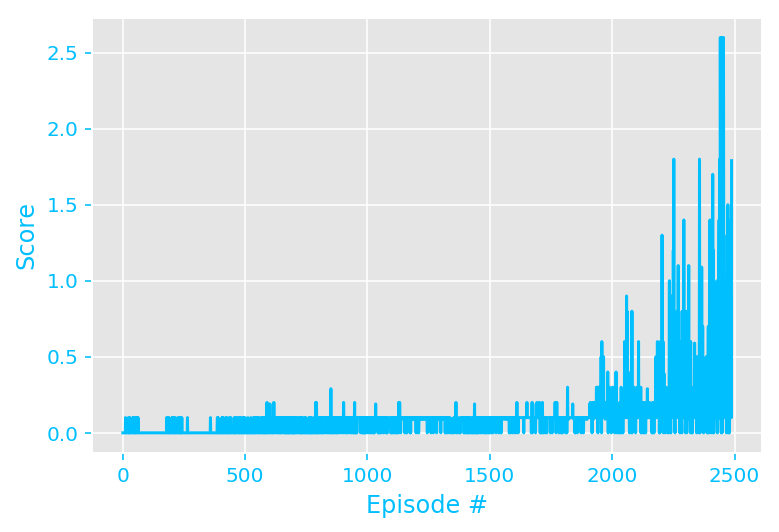

In [9]:
# Launch training
scores = train()
plot_training(scores)

In [10]:
env.close()